### 江苏省电网平均二氧化碳排放因子为0.7025 tCO_2/MWh

In [92]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/宿迁市行业月度电量.csv', encoding='gbk')
data.head()

,行业,月份,总电量
0,金融业,2023/5/1 0:00,2.284695e+06
1,B、城乡居民生活用电合计,2023/5/1 0:00,2.038725e+08
2,交通运输、仓储和邮政业,2023/5/1 0:00,1.333861e+07
3,住宿和餐饮业,2023/5/1 0:00,1.508271e+07
4,信息传输、软件和信息技术服务业,2023/5/1 0:00,1.175362e+08


In [93]:
len(data_cats[7])

53

In [103]:
cats = [ "B、城乡居民生活用电合计", "交通运输、仓储和邮政业", "住宿和餐饮业", "信息传输、软件和信息技术服务业", 
        "公共服务及管理组织", "农、林、牧、渔业", "工业", "建筑业", "房地产业", "批发和零售业", "租赁和商务服务业","金融业"]
data_cats = []
# 获得各个行业的用电量
for i, name in enumerate(cats):
    data_i = data[data['行业'] == name]
    data_i.index = pd.to_datetime(data_i['月份'].astype(str))
    data_i = data_i.sort_index()
    # print(data_i.shape)
    data_cats.append(data_i)

In [104]:
# 获得宿迁市总用电量得到对应的月度二氧化碳排放
load = data_cats[0]['总电量'].copy()
for i in range(1, len(cats)):
    load += data_cats[i]['总电量']

Text(0.5, 0, '时间')

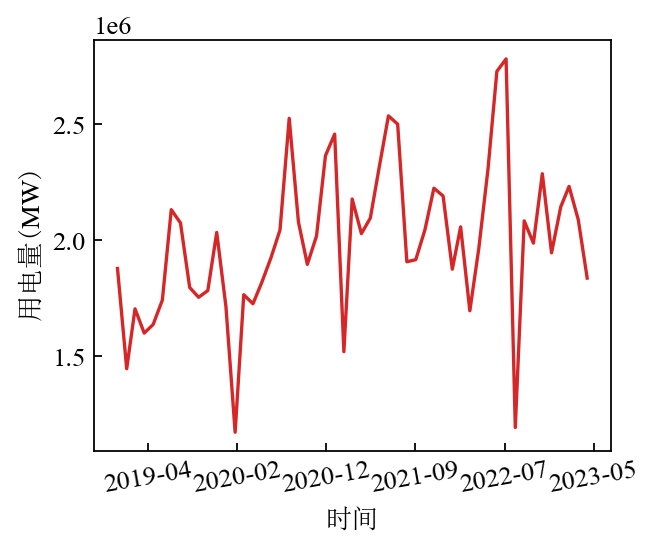

In [105]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdate
import matplotlib.ticker as ticker

# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.2, 4/1.2))
ax = fig.add_subplot(111)
ax.plot(load/1000, color=color_list[4], linestyle='-', linewidth=1.5)  # 真实值

ax.xaxis.set_major_locator(ticker.MultipleLocator(300))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(10)
legend_font = {"family":"SimSun", "size":10}
ax.set_ylabel('用电量($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
# ax.set_ylim([15,30])
# plt.legend(['观测值', '中位数', '99% 预测区间', '90% 预测区间', '50% 预测区间'],frameon=False, fontsize=10, bbox_to_anchor=(1.001, 1.02), prop=legend_font)

Text(0.5, 0, '时间')

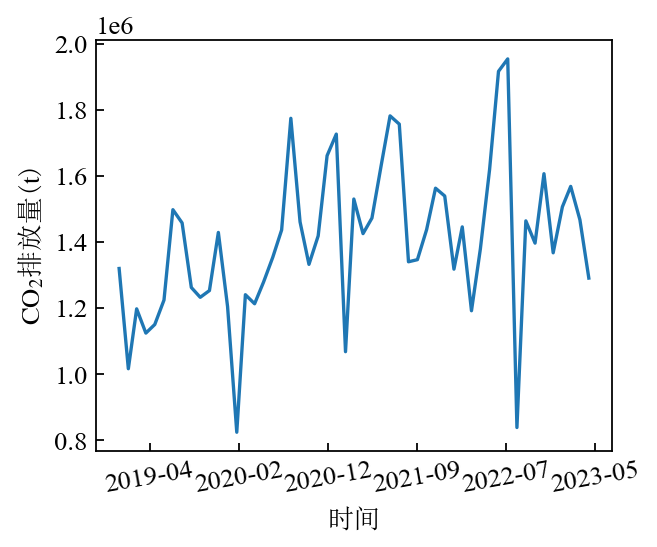

In [106]:
CO2 = load/1000*0.7025  # t

# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.2, 4/1.2))
ax = fig.add_subplot(111)
ax.plot(CO2, color=color_list[1], linestyle='-', linewidth=1.5)  # 真实值

ax.xaxis.set_major_locator(ticker.MultipleLocator(300))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(10)
legend_font = {"family":"SimSun", "size":10}
ax.set_ylabel('$\mathrm{CO_2}$排放量($\mathrm{t}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
# ax.set_ylim([15,30])
# plt.legend(['观测值', '中位数', '99% 预测区间', '90% 预测区间', '50% 预测区间'],frameon=False, fontsize=10, bbox_to_anchor=(1.001, 1.02), prop=legend_font)

### 优化碳排放因子

In [230]:
from scipy.optimize import minimize, Bounds

def min_function(x):
    global load_array_co2, data_cats_array

    return (((data_cats_array/1000*x.reshape(12,1)).sum(0) - load_array_co2)**2).sum()
   
    

lb = np.array([0.5, 0.1, 0.1, 0.1, 0.2, 0.4, 0.5, 0.2, 0.2, 0.2, 0.2, 0.2])  
print(lb.shape)
ub = np.array([0.78, 0.38, 0.4, 0.4, 0.6, 1.2, 1.5, 0.5, 0.4, 0.8, 0.6, 0.6])
a0 = np.array([0.65, 0.225, 0.25, 0.2, 0.4, 1, 0.6, 0.35, 0.3, 0.5, 0.4, 0.4])
am = 0.7025  # 单位 tCO_2/MWh
bnds = Bounds(lb=lb, ub=ub)

load_array = np.array(load)  # 每月负荷 单位kWh
data_cats_array = np.array([data_cats[i]['总电量'] for i in range(len(cats))])  # 各行业用电量 12,53
load_array_co2 = load_array/1000*am  # 每月CO2排放量 单位t


res = minimize(fun=min_function, x0=a0, bounds=bnds)


(12,)


In [231]:
res.x

array([0.76692874, 0.38      , 0.4       , 0.4       , 0.6       ,
       0.87158195, 0.73684   , 0.5       , 0.4       , 0.8       ,
       0.55303035, 0.55930097])

In [235]:
(data_cats_array/1000*res.x.reshape(12,1)).sum(0) 

array([1299279.04949567,  995373.60909972, 1183204.60133998,
       1110780.17924884, 1134134.68085012, 1210506.5991427 ,
       1492241.60212717, 1448703.23388224, 1249000.62830346,
       1219732.85123317, 1238601.91305613, 1414197.43230856,
       1192511.034328  ,  814412.45090705, 1243239.5899271 ,
       1213404.71989476, 1274979.98933229, 1350777.14422523,
       1434861.71426285, 1787110.93667151, 1463344.84146251,
       1333557.23210734, 1419612.42818293, 1660537.18631857,
       1730476.08125192, 1058652.64303826, 1532435.257069  ,
       1426982.34683555, 1469378.96108343, 1630352.9124136 ,
       1783494.24995808, 1765514.3058007 , 1346573.15395471,
       1364238.58661652, 1458661.43211562, 1580574.06027488,
       1546816.68291224, 1306769.68768898, 1439837.15823583,
       1180890.39533365, 1364531.85621889, 1612088.2406211 ,
       1923911.55794884, 1964859.89379437,  839754.66782145,
       1458798.75361205, 1403777.38794673, 1622598.01197639,
       1372747.92434771,

In [236]:
(load_array_co2 - (data_cats_array/1000*res.x.reshape(12,1)).sum(0))/load_array_co2

array([ 0.01552755,  0.0204966 ,  0.01202307,  0.01189807,  0.01399145,
        0.01113241,  0.00373328,  0.00620593,  0.01052135,  0.01035497,
        0.01147381,  0.01036388,  0.01006407,  0.01149048, -0.00233301,
       -0.00031937,  0.00263548,  0.00186939,  0.00110044, -0.00702686,
       -0.00165849, -0.00095782, -0.00073162,  0.00053867, -0.00214018,
        0.00867957, -0.00149105, -0.00108255,  0.00215677,  0.00075164,
       -0.00083842, -0.00484569, -0.00481277, -0.01316142, -0.01474444,
       -0.01126241, -0.00489454,  0.00834105,  0.00412339,  0.00916002,
        0.01084573,  0.00470696, -0.00367714, -0.00532888, -0.00171947,
        0.00356367, -0.005133  , -0.00980122, -0.00401606, -0.00846435,
       -0.0099225 , -0.0100342 , -0.00617381])

### 绘图

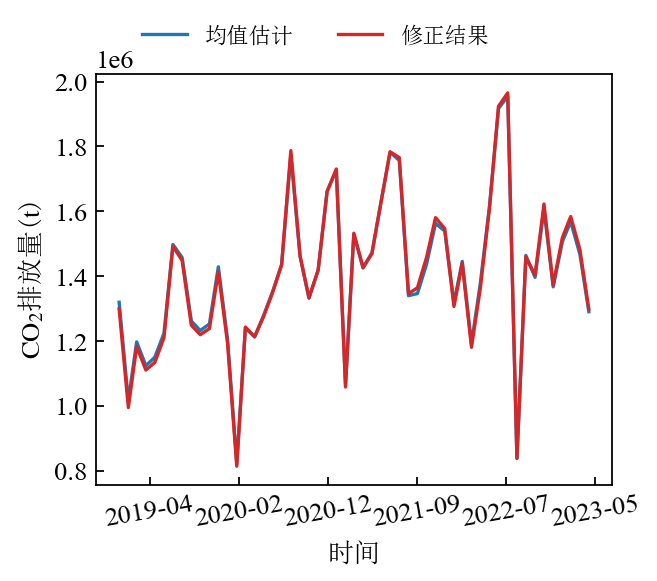

In [252]:
# 碳排放量历史曲线对比

# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.2, 4/1.2))
ax = fig.add_subplot(111)

x = pd.to_datetime(data_cats[i]['月份'].astype(str))
co2_mod = (data_cats_array/1000*res.x.reshape(12,1)).sum(0)

ax.plot(x, load_array_co2, color=color_list[1], linestyle='-', linewidth=1.5)  # 真实值
ax.plot(x, co2_mod, color=color_list[4], linestyle='-', linewidth=1.5)  # 真实值

ax.xaxis.set_major_locator(ticker.MultipleLocator(300))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(10)
legend_font = {"family":"SimSun", "size":10}
ax.set_ylabel('$\mathrm{CO_2}$排放量($\mathrm{t}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
# ax.set_ylim([15,30])
plt.legend(['均值估计', '修正结果'],frameon=False, fontsize=10, bbox_to_anchor=(0.8, 1.17), prop=legend_font, ncol=2)

### 碳排放量结果展示

In [286]:
# 最近2022年1月开始，占比
co2_cats = (data_cats_array/1000*res.x.reshape(12,1))
partion = (co2_cats[:,-12:].sum(1)/co2_cats[:,-13:].sum())*100
partion = co2_cats[:,-12:].sum(1)

In [287]:
d = {n:p for n,p in zip(cats,partion)}

d_order=sorted(d.items(),key=lambda x:x[1],reverse=True)                                                           
print(d_order) 

[('工业', 10907764.06669211), ('B、城乡居民生活用电合计', 3631261.8813966876), ('批发和零售业', 844026.440176), ('公共服务及管理组织', 744556.4538299999), ('农、林、牧、渔业', 724848.093236802), ('信息传输、软件和信息技术服务业', 721324.1736960001), ('房地产业', 130200.606416), ('建筑业', 111029.92992499999), ('住宿和餐饮业', 92169.4340196), ('租赁和商务服务业', 84263.70896166399), ('交通运输、仓储和邮政业', 66670.42713252), ('金融业', 24311.01853627785)]


### 绘制趋势

Text(0.5, 1.0, '农、林、牧、渔业逐月$\\mathrm{CO_2}$排放量')

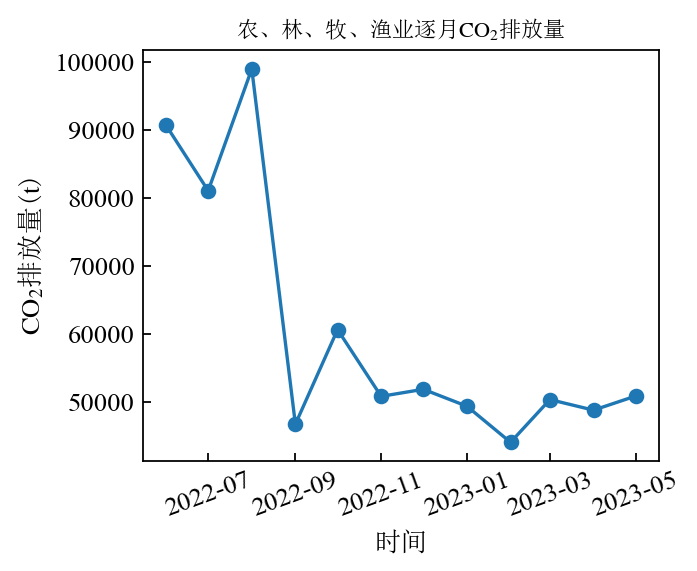

In [350]:
# 各个行业
cats_new = [ "城乡居民生活用电", "交通运输、仓储和邮政业", "住宿和餐饮业", "信息传输、软件和信息技术服务业", 
        "公共服务及管理组织", "农、林、牧、渔业", "工业", "建筑业", "房地产业", "批发和零售业", "租赁和商务服务业","金融业"]
cat_index = 5
### 绘制结果
config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.2, 4/1.2))
ax = fig.add_subplot(111)
x = pd.to_datetime(data_cats[i]['月份'].astype(str))
ax.plot(x[-12:], co2_cats[cat_index,-12:],  color=color_list[1], linestyle='-', marker='o')

# ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
     tick.set_rotation(20)
legend_font = {"family":"SimSun", "size":10}
ax.set_ylabel('$\mathrm{CO_2}$排放量($\mathrm{t}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
# ax.set_ylim([15,30])
# plt.legend([cats_new[cat_index]],frameon=False, fontsize=10, bbox_to_anchor=(0.4, 1.15), prop=legend_font)
plt.title(cats_new[cat_index]+"逐月$\mathrm{CO_2}$排放量", fontsize=10, fontfamily="SimSun")

In [ ]:
### 绘制结果
config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5, 4))
ax = fig.add_subplot(111)

x = pd.to_datetime(data_cats[i]['月份'].astype(str))
ax.plot(x[-12:], co2_cats[:,-12:][0,:],  color='k', linestyle='-', marker='o', label='实际负荷超限量')


In [ ]:
legend_font = {"family":"SimSun", "size":10}
#ax.legend([ '工业','公共服务及管理组织', '信息传输','农、林、牧、渔业','实际负荷超限量'],frameon=False, fontsize=10, prop=legend_font) # ncol=2   bbox_to_anchor=(0.3, 1.17)
ax.plot(np.arange(0,24), co2_cats[:,-12:],  color='k', linestyle='-', marker='o', label='实际负荷超限量')
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.set_ylabel('各行业调峰负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间(h)', fontfamily="SimSun")

ax.legend([ '实际负荷超限量', '工业','公共服务及管理组织', '信息传输','农、林、牧、渔业'],frameon=False, fontsize=10, prop=legend_font, bbox_to_anchor=(0.5, 0.65)) # ncol=2   bbox_to_anchor=(0.3, 1.17)